<a href="https://colab.research.google.com/github/Sompote/RIC_predict/blob/main/transformer_combind__attention_FS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This code is for a transformer for predict RIC results combindnation of LSTM and CON1D together to predict RIC
*   The feature was add to encoding data
*   initial qc value is in [:,:,0]




In [1]:
!pip install -q keras-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.1/880.1 kB 8.0 MB/s eta 0:00:00


In [2]:
import os

os.environ["KERAS_BACKEND"] = "jax"

# Note that keras_core should only be imported after the backend
# has been configured. The backend cannot be changed once the
# package is imported.
import keras_core as keras

Using JAX backend.


In [87]:
#Transformer Autoencoder to predict RIC combind model by Dr. Sompote Youwai 2023
import numpy as np
import pandas as pd

# Import libraries
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd



df = pd.read_excel('/content/drive/MyDrive/RIC/RIC3aug_revise.xlsx')
data=np.array(df)
X=data[:,1:29]
Y=data[:,34:62]
x_feature=data[:,29:32]

df_FS = pd.read_excel('/content/drive/MyDrive/RIC/FS_r.xlsx')
datafs=np.array(df_FS)
X_FS=datafs[:,1:29]



In [88]:
#scale data
X_train=X
Y_train=Y
sc_y=StandardScaler()
sc = StandardScaler()
sc_f=StandardScaler()
sc_fs=StandardScaler()

X_feature=x_feature
X_train=X

x_train = sc.fit_transform(X_train)
y_train=sc_y.fit_transform(Y_train)
x_feature=sc_f.fit_transform(X_feature)
x_fs=sc_fs.fit_transform(X_FS)




In [89]:
X_train_CNN=np.zeros((X.shape[0],X.shape[1],X_feature.shape[1]+2))
X_train_CNN[:,:,0]=x_train
X_train_CNN[:,:,1]=x_fs

for i in range(0,(X.shape[0])):
  X_train_CNN[i,:,2]=x_feature[i,0]
  X_train_CNN[i,:,3]=x_feature[i,1]
  X_train_CNN[i,:,4]=x_feature[i,2]

In [90]:
#split data
X_train, X_test, X_feature_train, X_feature_test, Y_train, Y_test = train_test_split(X_train_CNN, x_feature, y_train, random_state=1,test_size=0.1)

#_train, X_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2)
#X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
#X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))


In [91]:
X_train=X_train_CNN
Y_train=y_train
X_feature_train=x_feature


In [18]:
#Model generation part
#import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Conv1D, Flatten, concatenate,Reshape, Dropout,Bidirectional,LayerNormalization
from keras.layers import MaxPooling1D
from keras.layers import LSTM, Dense
from keras.metrics import MeanAbsolutePercentageError
from keras import *
from keras.optimizers import Adam
#from attention import Attention




def transformer_encoder(inputs, head_size, num_heads, ff_dim,
                        dropout=0.2, attention_axes=None):
  """
  Creates a single transformer block.
  """
  x = layers.LayerNormalization(epsilon=1e-6)(inputs)
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(x, x)
  x = layers.Dropout(dropout)(x)
  res = x + inputs

    # Feed Forward Part
  x = layers.LayerNormalization(epsilon=1e-6)(res)
  x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
  return x + res

def CNN_model(cnn_input_shape):
  # Create the CNN model
  cnn_input = Input(shape=cnn_input_shape,name='CNN_input')
  #cnn_output = Conv1D(filters=128, kernel_size=4, activation='sigmoid')(cnn_input)
  #cnn_output = Conv1D(filters=64, kernel_size=2, activation='sigmoid')(cnn_output)
  #cnn_output = Attention(units=32)(cnn_output)
  layer=transformer_encoder(cnn_input, head_size=24, num_heads=10, ff_dim=2,
                        dropout=0.25, attention_axes=(1,2))
  cnn_output = Flatten()(layer)
  cnn_output = Dense(50, activation='linear')(cnn_output)
  #cnn_output=  LayerNormalization(epsilon=1e-6)(cnn_output)

  cnn_model = Model(inputs=cnn_input, outputs=cnn_output,name='CNN_model')
  return cnn_model

def LSTM_model_attention(dense_input_shape):
  # Create the dense model
  # Use the function parameter as the input shape
  dense_input = Input(shape=dense_input_shape,name='LSTM_input')
  layer=transformer_encoder(dense_input, head_size=24, num_heads=10, ff_dim=2,
                        dropout=0.25,squences=True,attention_axes=(1,2))(layer)

  head_size=64
  num_heads=10
  ff_dim=2
  num_trans_blocks=12
  dropout=0.1
  attention_axes=1
  x = layers.LayerNormalization(epsilon=1e-6)(dense_output)
  x = layers.LayerNormalization(epsilon=1e-6)( x)
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(x, x)
  x = layers.Dropout(0.1)(x)
  res = x+dense_output
  #dense_output = Attention(units=32)(dense_output)
  layer = Flatten()(res)

  dense_output = Dense(200, activation='sigmoid')(layer)
  dense_output = Dense(50, activation='linear')(layer)

def LSTM_model(dense_input_shape):
  # Create the dense model
  # Use the function parameter as the input shape
  dense_input = Input(shape=dense_input_shape,name='LSTM_input')
  layer=transformer_encoder(dense_input, head_size=24, num_heads=10, ff_dim=2,
                        dropout=0.25, attention_axes=(1,2))

  dense_output = LSTM(200,return_sequences=True)(layer)

  layer = Flatten()(dense_output)

  dense_output = Dense(200, activation='sigmoid')(layer)
  dense_output = Dense(50, activation='linear')(layer)
  #dense_output=  LayerNormalization(epsilon=1e-6)(dense_output)

  dense_model = Model(inputs=dense_input, outputs=dense_output,name='LSTM_model')
  return dense_model

def encoding_model(LSTM_model,cnn_model,latent_dim):
  combined_input_cnn = cnn_model.output
  combined_input_LSTM = LSTM_model.output
  combined_input = concatenate([combined_input_LSTM,combined_input_cnn])
  layer=Dense(200, activation='sigmoid')(combined_input)
  combined_output = Dense(latent_dim, activation='linear')(layer)
  combined_model = Model(inputs=[LSTM_model.input,cnn_model.input], outputs=combined_output,name='encoding_model')
  return combined_model

def decoding_model1(latent_dim,feature_dim,time_step):
  inputs_l = Input(shape=latent_dim, name='latent')
  inputs_f = Input(shape=feature_dim, name='feature')
  layerf_int=  dense_output = Dense(40, activation='sigmoid')(inputs_f)
  layerfeature=  dense_output = Dense(latent_dim, activation='sigmoid')(layerf_int)
  combined_input = concatenate([inputs_l, layerfeature],name='combind_feature')
  layer=Dense(200, activation='sigmoid')(combined_input)
  layer=Dense(100, activation='tanh')(layer)
  layer=Dense(time_step, activation='tanh')(layer)
  layer=Reshape((time_step,1))(layer)
  LSTM_out =  LSTM(1,return_sequences=True)(layer)
  output=LSTM_out[:,:,0]


  #dense_output = Dense(time_step, activation='linear')(layer)

  model = Model([inputs_l,inputs_f], outputs=output,name='decoding_model')
  return model

def decoding_model(latent_dim,feature_dim,time_step):
  inputs_l = Input(shape=latent_dim, name='latent')
  inputs_f = Input(shape=feature_dim, name='feature')
  layerf_int=  Dense(40, activation='sigmoid')(inputs_f)
  layerfeature=  Dense(latent_dim, activation='sigmoid')(layerf_int)
  combined_input = concatenate([inputs_l, layerfeature],name='combind_feature')
  layer=Dense(200, activation='sigmoid')(combined_input)
  layer=Dropout(0.2)(layer)

  layer=Dense(100, activation='sigmoid')(layer)

  dense_output = Dense(time_step, activation='linear')(layer)
  output=dense_output
  model = Model([inputs_l,inputs_f], outputs=output,name='decoding_model')
  return model

def transformer(encoding_model,decoding_model,feature_dim):
  input_f = Input(shape=feature_dim, name='feature')
  #inputs_feature=Dense(feature_dim, activation='sigmoid')
  #inputs_f = decoding_model.input[1]
  input_l=encoding_model.output
  print(input_l)
  outputs = decoding_model([input_l,input_f])
  print(outputs)
  model = Model(inputs=[input_f,encoding_model.input], outputs=outputs,name='Transformer')
  return model



# Compile and summarize the combined model
#Main program

dense_input_shape = (X_train.shape[1])
cnn_input_shape = (X_train.shape[1],X_train.shape[2])
LSTM_input_shape=(X_train.shape[1],X_train.shape[2])


feature_dim=X_feature.shape[1]
latent_dim=26
time_step=Y_train.shape[1]
model_cnn=CNN_model(cnn_input_shape)
model_lstm= LSTM_model(LSTM_input_shape)

#model_combind=combind_model2(model_lstm,model_cnn,y_train)
model_encoding=encoding_model(model_lstm,model_cnn,latent_dim)
model_decoding=decoding_model(latent_dim,feature_dim,time_step)
model_transform=transformer(model_encoding,model_decoding,feature_dim)
#adam.learning_rate=0.001
model_transform.compile(optimizer='adam', loss='mse', metrics=['mae','mape'])
model_transform.summary()


#from tensorflow.keras.callbacks import ModelCheckpoint
callback = callbacks.EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True)




history=model_transform.fit([X_feature_train,X_train, X_train],
                            Y_train, epochs=2000, batch_size=20,validation_data=([X_feature_test,X_test,X_test], Y_test),callbacks=[callback])

KerasTensor(type_spec=TensorSpec(shape=(None, 26), dtype=tf.float32, name=None), name='dense_34/BiasAdd:0', description="created by layer 'dense_34'")
KerasTensor(type_spec=TensorSpec(shape=(None, 28), dtype=tf.float32, name=None), name='decoding_model/dense_39/BiasAdd:0', description="created by layer 'decoding_model'")
Model: "Transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 LSTM_input (InputLayer)        [(None, 28, 5)]      0           []                               
                                                                                                  
 layer_normalization_14 (LayerN  (None, 28, 5)       10          ['LSTM_input[0][0]']             
 ormalization)                                                                                    
                                                              

In [92]:
def mape(y_true, y_pred):
  mape=np.mean(np.abs((Y - y_pred)/Y))*100
  # return mean of percentage errors
  return mape


def mae(y_true, y_pred):
  mae=np.mean(np.abs(Y - y_pred))
  # return mean of percentage errors
  return mae

y=model_transform.predict([x_feature,X_train_CNN,X_train_CNN])
y_pred=sc_y.inverse_transform(y)

mape=mape(Y,y_pred)
mae=mae(Y,y_pred)

print('MAPE=', mape)
print('MAE=', mae)


1/1 [==============================] - 0s 171ms/step
MAPE= 7.458731184412287
MAE= 0.31042206786268


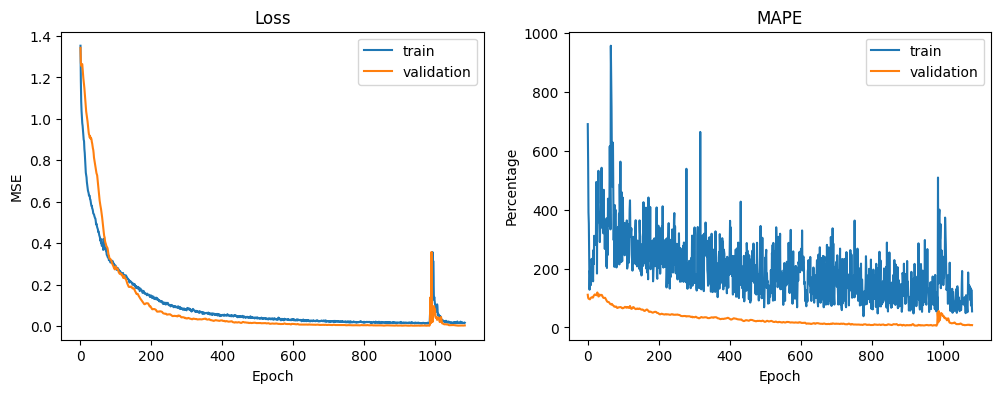

In [26]:

# plot the loss and mape for train and validation sets
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mape'], label='train')
plt.plot(history.history['val_mape'], label='validation')
plt.title('MAPE')
plt.xlabel('Epoch')
plt.ylabel('Percentage')
plt.legend()

plt.show()

Model: "Transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 LSTM_input (InputLayer)        [(None, 28, 5)]      0           []                               
                                                                                                  
 layer_normalization_14 (LayerN  (None, 28, 5)       10          ['LSTM_input[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 CNN_input (InputLayer)         [(None, 28, 5)]      0           []                               
                                                                                                  
 multi_head_attention_7 (MultiH  (None, 28, 5)       5525        ['layer_normalization_1

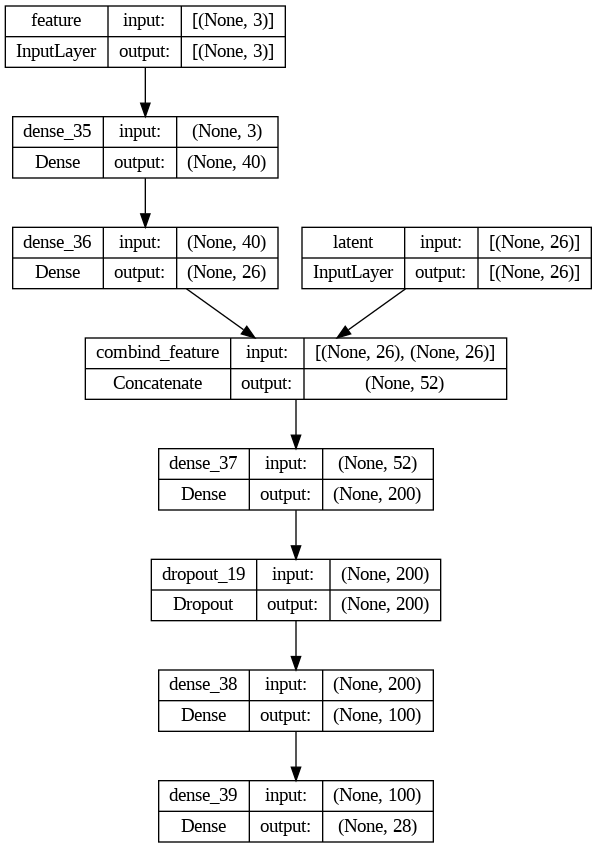

In [81]:
# plot and save your model
import tensorflow as tf
model_transform.summary()
img_file = 'model_transform.png'
tf.keras.utils.plot_model(model_transform, to_file=img_file, show_shapes=True, show_layer_names=True)
img_file = 'model_decode.png'
tf.keras.utils.plot_model(model_decoding, to_file=img_file, show_shapes=True, show_layer_names=True)

In [93]:
#validation
x_predictn=np.zeros((1,28))
#x_predictn[0,:]=[10,18,18,20,25,18,20,18,5,2,10,9,10,5,8,6,6,4,7,12,23,24,25,25,54,27,23]
x_predictn[0,:]=data[15,1:29]
X_predict = sc.transform(x_predictn)
x_feature=np.zeros((1,3))
x_feature[0,0]=50 #blow
x_feature[0,1]=2 #fine
x_feature[0,2]=3 #thickness
X_feature = sc_f.transform(x_feature)

x_cal=np.zeros((1,time_step,4))
x_cal[:,:,0]=X_predict
x_cal[:,:,1]=X_feature[0,0]
x_cal[:,:,2]=X_feature[0,1]
x_cal[:,:,3]=X_feature[0,2]
x_cal=X_train_CNN[0:1,:,:]
y=model_transform.predict([X_feature,x_cal,x_cal])
y=sc_y.inverse_transform(y)
print(y)
#plot


1/1 [==============================] - 0s 30ms/step
[[ 9.55116   10.305413  11.605457  13.249903  15.066756  13.9077835
  12.459053  13.79362   10.887519   3.7385023  0.5387245  0.3813451
   1.6233867  2.9135528  2.1064296  2.0734184  2.5172334  1.8830991
   3.7251222  3.1887448  2.2845962  1.8509846  3.6180034  4.0886154
   5.2746396  6.767727   8.88808   12.123287 ]]


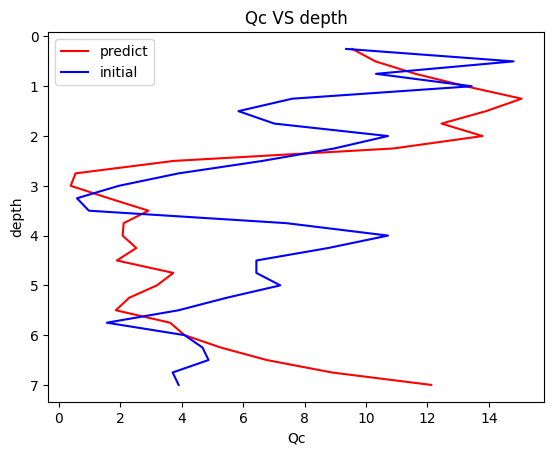

In [94]:
import matplotlib.pyplot as plt

# Define the x-axis and corresponding y-axis values as lists

ydist=[0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4,4.25,4.5,4.75,5,5.25,5.5,5.75,6,6.25,6.5,6.75,7]


# Plot them on canvas using plt.plot() function
plt.plot(y[0,:], ydist,color='red',label='predict')
plt.plot(x_predictn[0,:], ydist,color='blue',label='initial')
plt.legend()


# Give a name to x-axis and y-axis using plt.xlabel() and plt.ylabel() functions
plt.xlabel("Qc")
plt.ylabel("depth")

# Give a title to your plot using plt.title() function
plt.title("Qc VS depth")
# Get the current axes instance
ax = plt.gca()

# Invert the y-axis
ax.invert_yaxis()

# Finally, to view your plot, we use plt.show() function
plt.show()

In [ ]:
model_transform.save('transformer.h5')

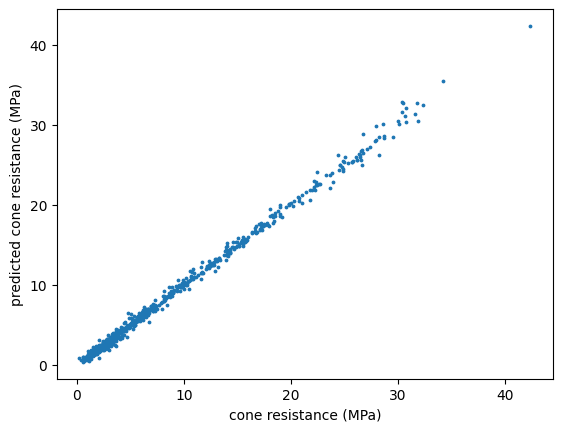

In [96]:
import matplotlib.pyplot as plt


Y=data[:,34:62]

# Plot the data points as a scatter plot
plt.scatter(y_pred, Y, s=3)

# Add labels and title
plt.xlabel('cone resistance (MPa)')
plt.ylabel('predicted cone resistance (MPa)')


# Show the plot on the screen
plt.show()

In [ ]:
com=np.concatenate((y_pred,Y),axis=0)
np.savetxt('predict.csv', com, delimiter=',')

In [118]:
#Transformer Autoencoder to predict RIC combind model by Dr. Sompote Youwai 2023
import numpy as np
import pandas as pd

# Import libraries
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd



df2 = pd.read_excel('/content/drive/MyDrive/RIC/test_data.xlsx')
data=np.array(df2)
X_t=data[0:2,1:29]
Y_t=data[0:2,34:62]
X_feature_t=data[0:2,29:32]
FC_X_t=data[3:5,1:29]



In [43]:
FC_X_t

array([[0.06089965, 0.13010381, 0.19653979, 0.34602076, 0.27404844,
        0.19377163, 0.19377163, 0.30726644, 0.19653979, 0.20484429,
        0.29619377, 0.39861592, 0.3349481 , 0.18269896, 0.07474048,
        0.05259516, 0.13010381, 0.1716263 , 0.08304498, 0.06920415,
        0.08581315, 0.09688581, 0.10795848, 0.12733564, 0.11626298,
        0.06089965, 0.02768166, 0.16608997],
       [0.06315789, 0.11368421, 0.26947368, 0.31578947, 0.31578947,
        0.24      , 0.13894737, 0.09263158, 0.03368421, 0.19789474,
        0.24      , 0.31157895, 0.30736842, 0.19789474, 0.15578947,
        0.34526316, 0.26105263, 0.16421053, 0.12210526, 0.07157895,
        0.06315789, 0.05894737, 0.05894737, 0.06315789, 0.07157895,
        0.02105263, 0.02947368, 0.02947368]])

In [119]:
#scale data
X_train=X_t
Y_train=Y_t


x_feature=X_feature


X= sc.transform(X_train)
y_train=sc_y.transform(Y_train)
x_feature=sc_f.transform(X_feature_t)
x_fs=sc_fs.transform(FC_X_t)


In [55]:
x_fs

array([[-1.62048381, -1.1879588 , -0.78276573,  0.32560843,  0.61157056,
         0.07740103,  0.84714092,  1.85170415,  0.50797222,  0.6580291 ,
         1.20880465,  2.05344156,  1.79502418,  0.27163107, -1.22439936,
        -1.168064  , -0.36307481,  0.49617347, -0.37600557, -0.46667635,
        -0.23772181, -0.00564396, -0.12459617, -0.2443307 , -0.53744688,
        -0.96004101, -1.15162749, -0.38905296],
       [-1.61264209, -1.23342438, -0.29181298,  0.21094315,  0.88211951,
         0.28514798,  0.32743939, -0.04997275, -0.69752658,  0.60735179,
         0.84605543,  1.38616866,  1.54607618,  0.45297532,  0.01845193,
         1.79363175,  1.08049898,  0.39953871,  0.11940452, -0.43431191,
        -0.62113997, -0.71771615, -0.83102113, -0.92039685, -0.90314424,
        -1.22867802, -1.14000814, -1.11099882]])

In [120]:
X_train_CNN=np.zeros((X.shape[0],X.shape[1],X_feature.shape[1]+2))
X_train_CNN[:,:,0]=X
X_train_CNN[:,:,1]=x_fs

for i in range(0,(X.shape[0])):
  X_train_CNN[i,:,2]=x_feature[i,0]
  X_train_CNN[i,:,3]=x_feature[i,1]
  X_train_CNN[i,:,4]=x_feature[i,2]

In [121]:
y=model_transform.predict([x_feature,X_train_CNN,X_train_CNN])
y_pred=sc_y.inverse_transform(y)

1/1 [==============================] - 0s 45ms/step


In [ ]:
np.savetxt('array2.csv', y_pred, delimiter=',')

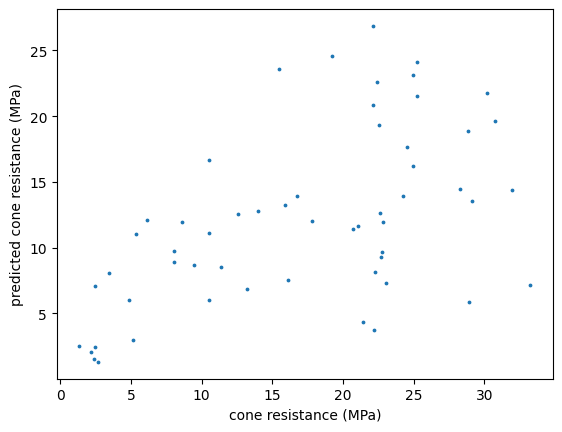

In [122]:
import matplotlib.pyplot as plt


Y=data[0:2,34:62]

# Plot the data points as a scatter plot
plt.scatter(Y, y_pred, s=3)

# Add labels and title
plt.xlabel('cone resistance (MPa)')
plt.ylabel('predicted cone resistance (MPa)')


# Show the plot on the screen
plt.show()

In [130]:
def mape(y_true, y_pred):
  mape=np.mean(np.abs((Y - y_pred)/Y))*100
  # return mean of percentage errors
  return mape


def mae(y_true, y_pred):
  mae=np.mean(np.abs(Y - y_pred))
  # return mean of percentage errors
  return mae
mape=mape(Y[0,:],y_pred[0,:])
mae=mae(Y,y_pred)

print('MAPE=', mape)
print('MAE=', mae)

MAPE= 43.018055482973686
MAE= 6.927664629479925


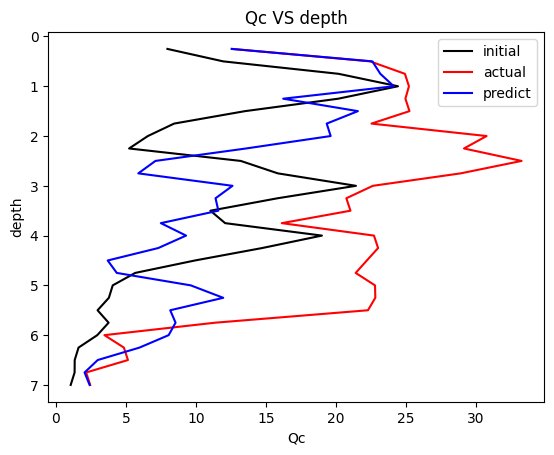

In [127]:
import matplotlib.pyplot as plt

# Define the x-axis and corresponding y-axis values as lists

ydist=[0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4,4.25,4.5,4.75,5,5.25,5.5,5.75,6,6.25,6.5,6.75,7]


# Plot them on canvas using plt.plot() function
plt.plot(X_t[1,:], ydist,color='black',label='initial')
plt.plot(Y[1,:], ydist,color='red',label='actual')
plt.plot(y_pred[1,:], ydist,color='blue',label='predict')
plt.legend()


# Give a name to x-axis and y-axis using plt.xlabel() and plt.ylabel() functions
plt.xlabel("Qc")
plt.ylabel("depth")

# Give a title to your plot using plt.title() function
plt.title("Qc VS depth")
# Get the current axes instance
ax = plt.gca()

# Invert the y-axis
ax.invert_yaxis()

# Finally, to view your plot, we use plt.show() function
plt.show()